Intialize:

In [1]:
getwd()

[1] "/hpc/hub_oudenaarden/agiladi/data/tuft_release/release_code"

In [2]:
setwd("..")

In [3]:
library(metacell)
library(RColorBrewer)

library(clusterProfiler)
library(ChIPpeakAnno) # for turning symbols into EntrezID
library(org.Hs.eg.db)

library(ggrepel)
library(flowCore)
library(flowWorkspace)

library(Hmisc)

source("release_code/metacell_functions.r")

scdb_init("saved_work", force=T)


Warning message:
“namespace ‘cachem’ is not available and has been replaced
by .GlobalEnv when processing object ‘’”
Bioconductor version '3.10' is out-of-date; the current release version '3.19'
  is available with R version '4.4'; see https://bioconductor.org/install
Registered S3 method overwritten by 'enrichplot':
  method               from
  fortify.enrichResult DOSE
clusterProfiler v3.14.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.
Loading required package: grid
Loading required package: IRanges
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, cl

In [4]:
outdir = "release_figures/fig3_organoids/"
dir.create(outdir)

Warning message in dir.create(outdir):
"'release_figures/fig3_organoids' already exists"

Load metacell objects and create environment

In [5]:
#id = "intestinal_tufts_organoid"
id = "ileum_organoids"

suffix = ""; id_f = paste0(id, suffix)
sc_2d = scdb_mc2d(id); sc_cl = scdb_mc(paste0(id, suffix)); sc_mat = scdb_mat(id)

cells = names(sc_cl@mc)
cell_stats = sc_mat@cell_metadata[cells,]
colnames(cell_stats) = gsub(" ", ".", colnames(cell_stats))
colnames(cell_stats) = gsub("\\(|\\)", "_", colnames(cell_stats))
fp = sc_cl@mc_fp
lfp = log2(sc_cl@mc_fp)

color_scheme = sc_cl@color_key
color2name = as.vector(color_scheme$group); names(color2name) = color_scheme$color
name2color = as.vector(color_scheme$color); names(name2color) = color_scheme$group
sc_names = color2name[ sc_cl@colors[ sc_cl@mc]]; names(sc_names) = names(sc_cl@mc)
annotations = as.matrix(read.delim(paste0("release_import/figure3_cs2//lin_ord_", id, ".txt"), stringsAsFactor=F, h=F))[,1]
lin_ord = annotations


In [6]:
message(length(cells), " cells")
message(length(table(sc_cl@mc)), " metacells")
write.table(lin_ord, quote=F, row.names=F, col.names=F)

953 cells
16 metacells


Stem cells
Goblet cells-1
Goblet cells-2
Tuft-1
Tuft-2
Tuft-3
Tuft-4


In [7]:
good_cells = sample(rownames(cell_stats)[ cell_stats$source == "Ileum"])
length(good_cells)

[1] 953

png 
  2

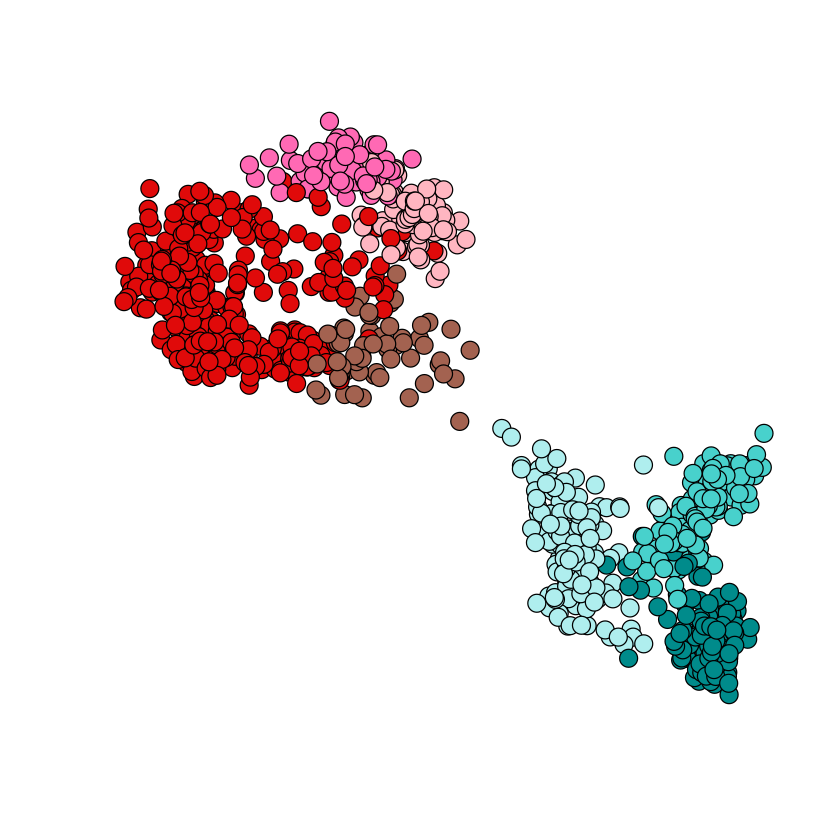

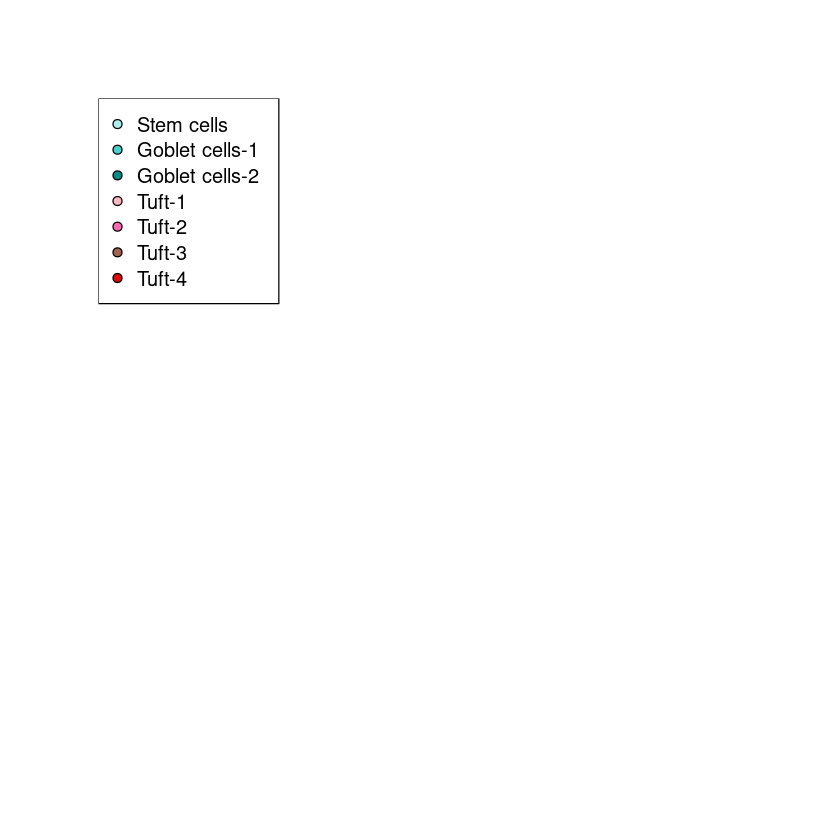

In [8]:
all_cells = intersect(names(sc_2d@sc_x), names(sc_cl@mc))

p = function() {
    plot(sc_2d@sc_x[all_cells], sc_2d@sc_y[all_cells], pch = 20, col = "gray",
        axes = F, xlab = "", ylab = "", cex = 1)
    points(sc_2d@sc_x[good_cells], sc_2d@sc_y[good_cells], pch = 21, bg = sc_cl@colors[ sc_cl@mc[good_cells]], cex=2)
}

p()
pdf(paste0(outdir, "/Fig3c.pdf"), useDingbats=F, height=10, width=10)
p()
dev.off()

plot.empty()
legend("topleft", lin_ord, pch=21, pt.bg = name2color[ lin_ord])


In [9]:
tuft_pops = grep("Tuft", lin_ord, v=T)
write.table(tuft_pops, quote=F, row.names=F)
tuft_mc = which(color2name[ sc_cl@colors] %in% tuft_pops)
tuft_cells = intersect(names(sc_names)[ sc_names %in% tuft_pops], rownames(cell_stats)[ cell_stats$gating == "AVIL-Clover+"])
length(tuft_cells)

x
Tuft-1
Tuft-2
Tuft-3
Tuft-4


[1] 573

In [10]:
comb = paste0(ifelse(sc_names[good_cells] %in% tuft_pops, "Tuft", "Epithel"), "@", cell_stats[ good_cells, "treatment"])
names(comb) = good_cells
table(comb)
table(sc_names[good_cells] %in% tuft_pops)
cols = c("gray40", "gray90", "darkorange2", "antiquewhite")

comb
Epithel@IL4+IL13  Epithel@no_cyto    Tuft@IL4+IL13     Tuft@no_cyto 
             185              188              406              174 


FALSE  TRUE 
  373   580 

png 
  2

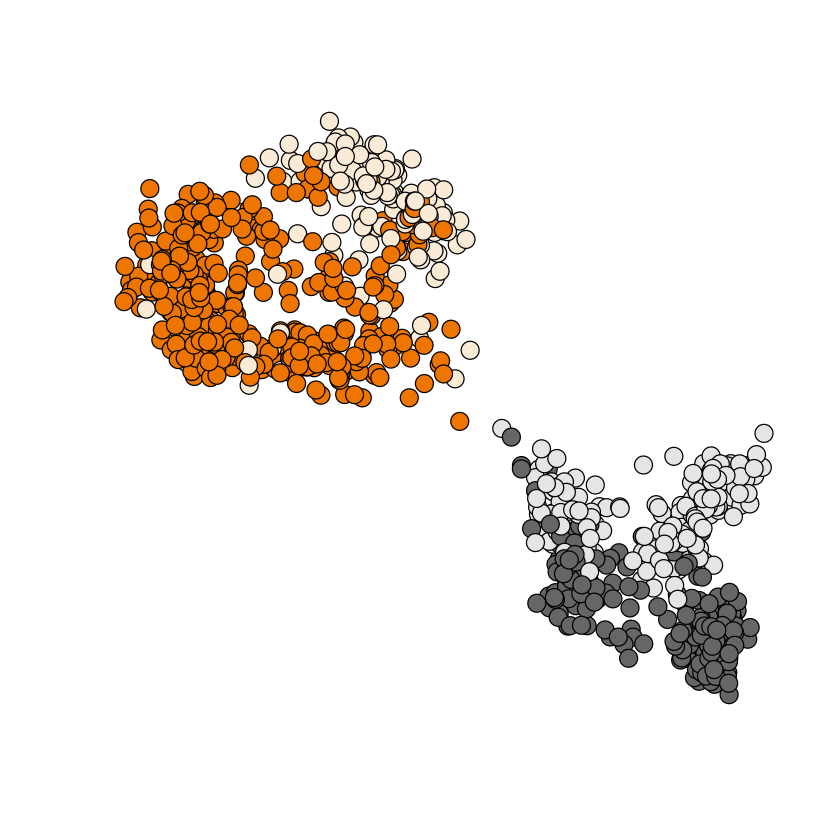

In [11]:
p = function() {
    plot(sc_2d@sc_x[all_cells], sc_2d@sc_y[all_cells], pch = 20, col = "gray",
        axes = F, xlab = "", ylab = "", cex = 1)
    points(sc_2d@sc_x[good_cells], sc_2d@sc_y[good_cells], pch = 21, cex = 2, bg = cols[ as.numeric(factor(comb[good_cells]))])
}

p()
pdf(paste0(outdir, "/Fig3b.pdf"), useDingbats=F, height=10, width=10)
p()
dev.off()


In [12]:
sample_dist = table(factor(cell_stats[ tuft_cells, "treatment"], levels = c("no_cyto", "IL4+IL13")), sc_names[ tuft_cells])
sample_dist = sample_dist[, intersect(lin_ord, colnames(sample_dist))]
summarize.table(sample_dist)

,Tuft-1,Tuft-2,Tuft-3,Tuft-4,total
no_cyto,59,79,7,28,173
IL4+IL13,14,13,57,316,400
total,73,92,64,344,573


In [13]:
dist_n = sample_dist / rowSums(sample_dist)


bconf = sapply(colnames(sample_dist), function(c)
    binconf(sample_dist[,c], rowSums(sample_dist))) * 100

pointEst = bconf[1:2,]; dimnames(pointEst) = dimnames(dist_n)
lower = bconf[3:4,]
upper = bconf[5:6,]


png 
  2

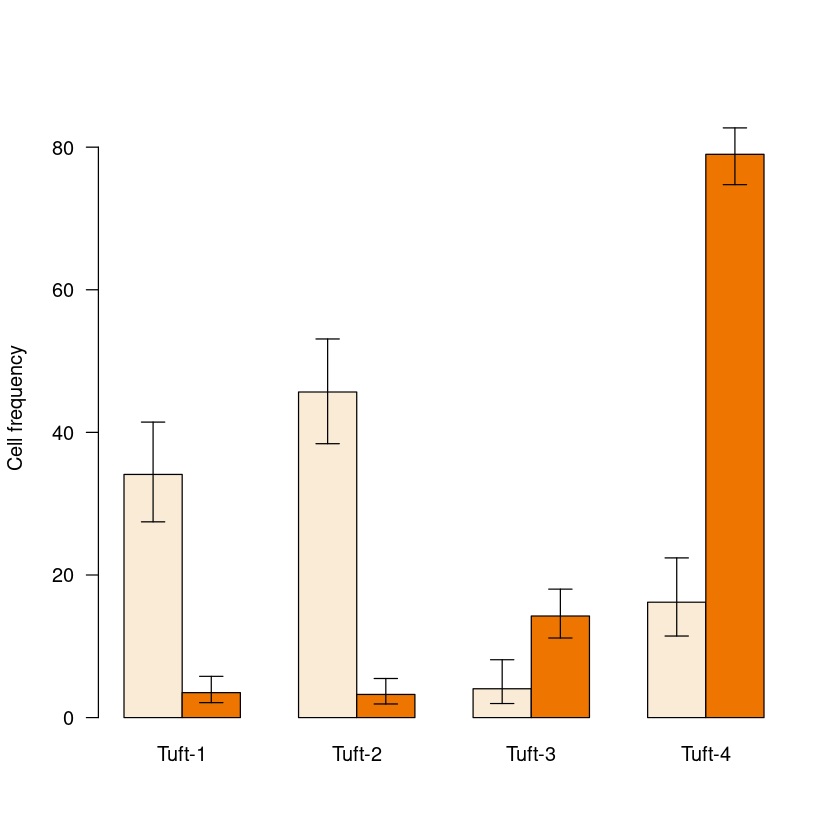

In [14]:
#par(mar = c(10,7,3,1))

p = function(){
    coords = barplot(pointEst, beside=T, axes = F, ylab = "Cell frequency", ylim = c(0, 1.05 * max(upper)),
        col = c("antiquewhite", "darkorange2"))
    axis(2, las = 2)
    segments(coords, lower, y1 = upper)
    segments(coords - 0.2, lower, coords + 0.2)
    segments(coords - 0.2, upper, coords + 0.2)
}

p()
pdf(paste0(outdir, "/Fig3e.pdf"), useDingbats = F, height=5, width=7)
p()
dev.off()



In [15]:
umis = read_large_umis(id, cells = good_cells)
umis_n = sweep(umis, 2, cell_stats[ good_cells, "umicount"], "/") * 1000

In [16]:
clust_ord = setdiff(order(factor(color2name[ sc_cl@colors], levels = lin_ord)), c())

In [17]:
comb = ifelse(sc_names[ good_cells] %in% tuft_pops, sc_names[ good_cells], "Epithel")
#comb = sc_names[ good_cells]
names(comb) = good_cells

head(comb)
m = t(apply(umis_n[names(which(rowSums(umis[,good_cells]) > 50)), good_cells], 1, tapply, comb[ good_cells], mean))
m = m[, names(which(table(comb[ good_cells]) > 20))]
message(nrow(m), " genes with >100 total UMI")
head(m)

HUB.JO.s037_CCACAACT HUB.JO.s037_CCTGCTAT HUB.JO.s043_ACGCTCTT 
            "Tuft-4"             "Tuft-3"            "Epithel" 
HUB.JO.s042_ATATTCCC HUB.JO.s043_CTACGCTG HUB.JO.s043_CTTAGCCT 
           "Epithel"            "Epithel"             "Tuft-4"

10706 genes with >100 total UMI


,Epithel,Tuft-1,Tuft-2,Tuft-3,Tuft-4
A1CF,0.06020041,0.01173844,0.01011823,0.00160098,0.005566939
AAAS,0.05103808,0.03502004,0.03618921,0.05549242,0.039219935
AACS,0.07046061,0.10468680,0.11965501,0.08296389,0.104205929
AAGAB,0.03435744,0.05570533,0.03297928,0.06453722,0.047384473
AAK1,0.04001441,0.05981932,0.07651250,0.04470635,0.050796735
AAMP,0.06110125,0.04132816,0.06782365,0.06784748,0.056242316


In [18]:
bg = "Epithel"
reg = 0.02
Z = log2((reg + m[,tuft_pops]) / (reg + m[,bg]))
diff_genes = sapply(tuft_pops, function(x) scr_chi_square_diff_genes(umis, g1 = names(which(comb == x)), g2 = names(which(comb == bg)), 
                                  pval = 0.01, fdr = T))
length(diff_genes)
sapply(diff_genes, length)
                    

[1] 4

Tuft-1 Tuft-2 Tuft-3 Tuft-4 
  1816   2453   2534   5145

In [19]:
names(diff_genes) = paste0(names(diff_genes), "@")
diff_genes = unlist(diff_genes)
diff_genes = table(diff_genes, vecsplit(names(diff_genes), "@", 1))
head(diff_genes)
head(Z)

          
diff_genes Tuft-1 Tuft-2 Tuft-3 Tuft-4
     A1CF       0      1      1      1
     AACS       0      1      0      1
     AADAT      0      0      0      1
     AARS1      0      0      0      1
     AASDH      0      0      0      1
     AATK       0      0      0      1

,Tuft-1,Tuft-2,Tuft-3,Tuft-4
A1CF,-1.3373783,-1.4129725,-1.89251284,-1.64933016
AAAS,-0.3686354,-0.3382994,0.08773918,-0.26250970
AACS,0.4629472,0.6265057,0.18677690,0.45737248
AAGAB,0.4779174,-0.0370493,0.63710914,0.30993865
AAK1,0.4114291,0.6854069,0.10859837,0.23837396
AAMP,-0.4031745,0.1148855,0.11527684,-0.08913214


In [20]:
shared = intersect(rownames(diff_genes), rownames(Z))
core_genes = names(which(rowSums(diff_genes[shared,] == 1 & Z[ shared, colnames(diff_genes)] > 1) == ncol(diff_genes)))
sort(core_genes)

[1] "ABCB9"       "ABHD2"       "AC007906.2"  "AC068050.1"  "ACADSB"     
  [6] "ACSL4"       "ADGRG6"      "ALDH1A1"     "ALKAL1"      "ALOX5"      
 [11] "ALOX5AP"     "ANKS4B"      "ANXA1"       "ANXA4"       "AOC1"       
 [16] "APOBEC1"     "ARHGAP4"     "ARPC5"       "ASCL2"       "ATP12A"     
 [21] "ATP2A3"      "ATP2B4"      "AVIL"        "AZGP1"       "B3GNT5"     
 [26] "B4GALNT4"    "BCAM"        "BIK"         "BMX"         "BUB3"       
 [31] "C11orf53"    "C19orf57"    "CACYBP"      "CALM2"       "CASC1"      
 [36] "CASP7"       "CASZ1"       "CC2D1A"      "CCDC115"     "CCSER1"     
 [41] "CD14"        "CD24"        "CDCP1"       "CDS1"        "CEACAM1"    
 [46] "CEACAM19"    "clover"      "CMTM3"       "CNN3"        "COL27A1"    
 [51] "CORO2B"      "CRYM"        "CSK"         "CTDSPL"      "CTSC"       
 [56] "CTSV"        "CTXND1"      "DCLK2"       "DCP2"        "DEPDC1B"    
 [61] "DNAL1"       "DPYSL3"      "EID1"        "EIF1B"       "EIF5"       
 [66] "EPS8L3"      "ESPL1"       "FAM217B"     "FOXC1"       "FURIN"      
 [71] "FYB1"        "GADD45A"     "GCH1"        "GCLC"        "GFI1B"      
 [76] "GLRX"        "GNAI1"       "GNAI2"       "GNAT3"       "GNB3"       
 [81] "GNG13"       "GPR153"      "GPT2"        "GRASP"       "GRK5"       
 [86] "GRK6"        "H1-10"       "HCK"         "HEPACAM2"    "HIGD1A"     
 [91] "HK2"         "HMCES"       "HMX2"        "HMX3"        "HOTAIRM1"   
 [96] "HOXA3"       "HOXC9"       "HTR3E"       "IFT27"       "IGFBP2"     
[101] "IGSF3"       "IL13RA1"     "IL17RB"      "IL19"        "IL27RA"     
[106] "IMP4"        "INPP5D"      "ITFG1"       "ITGB3"       "ITPRID1"    
[111] "KAZN"        "KCNN3"       "KCNQ1"       "KCNQ4"       "KDM4A"      
[116] "KIT"         "KLF4"        "KLHDC10"     "KLHDC7A"     "KLK13"      
[121] "KRT18"       "LACTB2"      "LCK"         "LINC00920"   "LINC01548"  
[126] "LIPG"        "LRMP"        "LRRN2"       "LYPLA1"      "MAFF"       
[131] "MAP1B"       "MAP7"        "MARC1"       "MARCKSL1"    "MATK"       
[136] "MAX"         "MBD4"        "MEGF9"       "MELTF"       "MICAL2"     
[141] "MIEN1"       "MISP3"       "MOB1B"       "MRPL15"      "MTA3"       
[146] "MTSS1"       "MYEOV"       "MYLK"        "MYO15B"      "MYO1B"      
[151] "NAB1"        "NCAM1"       "NCK2"        "NCMAP"       "NIN"        
[156] "NMU"         "NRCAM"       "NRTN"        "NXPH4"       "OGDHL"      
[161] "ORMDL1"      "PANK3"       "PAPSS2"      "PAQR5"       "PBXIP1"     
[166] "PDLIM5"      "PEAK1"       "PHF20L1"     "PHLDA1"      "PIK3C2B"    
[171] "PIK3CG"      "PIR"         "PLA2G4A"     "PLAC8"       "PLCG2"      
[176] "PLEKHB1"     "POU2F1"      "POU2F3"      "PPARGC1B"    "PRKAR2B"    
[181] "PROX1"       "PRSS12"      "PRSS3"       "PSTPIP2"     "PTGS1"      
[186] "PTPN18"      "PTPN6"       "PTPRG"       "PTPRJ"       "PTPRJ-AS1"  
[191] "PVR"         "PYGL"        "RAC2"        "RAD54L2"     "RASSF6"     
[196] "RBM38"       "RFK"         "RGS13"       "RNF186"      "RNF5"       
[201] "RP9P"        "RTN4"        "RUNX1"       "SEC14L1"     "SEPTIN2"    
[206] "SH2D6"       "SH2D7"       "SKAP2"       "SLC1A4"      "SLC41A1"    
[211] "SLCO3A1"     "SLCO4A1-AS1" "SNRNP27"     "SNX9"        "SOX13"      
[216] "SOX2"        "SOX9"        "SPIB"        "SPTLC2"      "ST18"       
[221] "STAT6"       "STK38"       "SUCNR1"      "TAS1R3"      "TCEA1"      
[226] "TCF7"        "TET2"        "TLE4"        "TMEM131L"    "TMEM170A"   
[231] "TMEM176A"    "TMEM176B"    "TMEM198"     "TMEM45B"     "TPD52L1"    
[236] "TRAK1"       "TREH"        "TRPM5"       "TUBA1A"      "TUBG2"      
[241] "UNC5B"       "UTRN"        "VAV1"        "VIPR1"       "VIPR1-AS1"  
[246] "VWA1"        "ZC3H12A"     "ZDHHC3"      "ZFHX3"       "ZNF280B"

In [21]:
head(Z[core_genes,])

,Tuft-1,Tuft-2,Tuft-3,Tuft-4
ABCB9,1.697179,2.075798,1.937576,1.658741
ABHD2,1.730621,2.152023,1.124042,1.420837
AC007906.2,1.494509,1.665384,1.962753,2.301553
AC068050.1,1.451500,1.776357,1.284213,2.978039
ACADSB,1.692700,1.180255,1.842840,1.558486
ACSL4,2.560877,2.875449,1.764714,2.561812


In [22]:
shared = intersect(rownames(diff_genes), rownames(Z))
double_genes = diff_genes[shared,] == 1 & Z[ shared, colnames(diff_genes)] > 1
table(rowSums(double_genes))


   0    1    2    3    4 
3970  554  272  178  250 

In [23]:
gene_anno_ep = apply(double_genes, 1, function(x) paste0(colnames(double_genes)[x], collapse = ","))
gene_anno_ep[ core_genes] = "Core"
good_genes = names(which(gene_anno_ep != ""))
df = data.frame(m[ good_genes,], annotation = gene_anno_ep[ good_genes])
head(df)
                     
write.table(df, sep = "\t", quote=F, col.names=NA, file = paste0(outdir, "/TableS1.txt"))

,Epithel,Tuft.1,Tuft.2,Tuft.3,Tuft.4,annotation
ABCB9,0.008008547,0.07082227,0.09807773,0.08728995,0.06843444,Core
ABCC5,0.013309684,0.04658836,0.05979230,0.04270755,0.02920503,Tuft-2
ABCD3,0.086634859,0.18183217,0.23226639,0.19632158,0.20454246,"Tuft-2,Tuft-3,Tuft-4"
ABHD2,0.238401096,0.83755753,1.12846480,0.54320280,0.67184507,Core
AC002044.1,0.003105643,0.01327180,0.02754018,0.03676239,0.02802361,"Tuft-2,Tuft-3,Tuft-4"
AC002044.2,0.012047669,0.08689081,0.03292486,0.07681558,0.08977250,"Tuft-1,Tuft-3,Tuft-4"


png 
  2

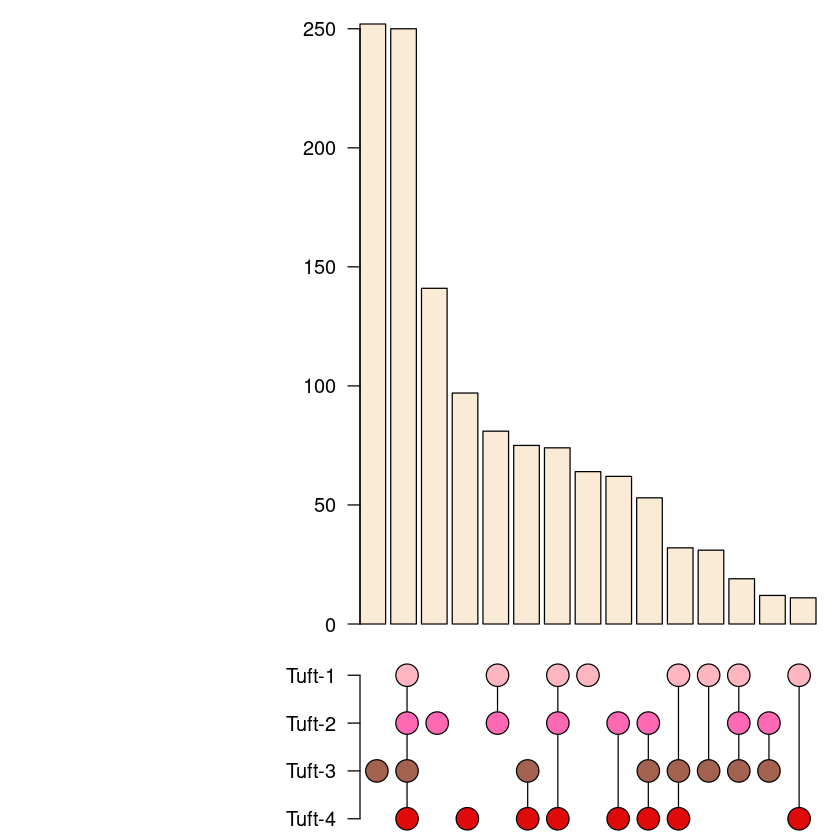

In [24]:
p = function() {
    X = apply(double_genes[ rowSums(double_genes) > 0,], 1, function(x) paste0(colnames(double_genes)[ x], collapse = ","))
    Y = sort(table(X), T)

    par (mar = c(0, 15, 1, 1), fig = c(0,1,0.25,1))          
    coords = barplot(Y, names.arg = rep("", length(Y)), las=2, xaxs="i", col = "antiquewhite")

    Z = strsplit(names(Y), ",")
    names(Z) = paste0(seq_along(Z), "@")
    Z = unlist(Z)
    X = t(table(as.numeric(vecsplit(names(Z), "@", 1)), factor(Z, levels = rev(tuft_pops))))

    par(fig = c(0,1,0,0.25), new=T)  
    hmed = seq(0, 1, length.out = nrow(X))
    vmed = seq(min(coords), max(coords), length.out = ncol(X))
    cex_val = X * 2.5
    #col = c("gray80", "gray20")[ col_val]
    plot(1,1,type="n", xlim = quantile(coords, c(0,1)), ylim = c(-0.1, 1.1), axes = F, xlab = "", ylab = "")          
    invisible(sapply(as.numeric(colnames(X)), function(x) lines(rep(vmed[x], sum(X[,x])), hmed[which(X[,x] == 1)]))) 
    points(rep(vmed, each = nrow(X)), rep(hmed, ncol(X)), pch = 21, 
        bg = name2color[ rep(rownames(X), ncol(X))], cex = cex_val, xlab = "", ylab = "",# xaxs="i",
        xlim = quantile(coords, c(0,1)), ylim = c(-0.1, 1.1))
    axis(2, at = hmed, labels = rownames(X), las = 2)

    
}
                     
p()
                     
pdf(paste0(outdir, "/Fig3f.pdf"), height=4, width=7, useDingbats = F)
p()
dev.off()


In [27]:
core_genes = names(which(rowSums(!double_genes) == 0))
disp_genes = union(names(head(sort(apply(Z[core_genes,],1, min), T), 20)), c("GNAT3","AVIL"))
sort(disp_genes)

[1] "ALOX5"   "ALOX5AP" "ANXA1"   "AVIL"    "AZGP1"   "BMX"     "DPYSL3" 
 [8] "GNAT3"   "GNG13"   "GRK5"    "HCK"     "HMX3"    "KIT"     "LRMP"   
[15] "NMU"     "PLCG2"   "POU2F3"  "PSTPIP2" "PTGS1"   "SH2D6"   "SH2D7"  
[22] "SPIB"

zlim: 0<>1
zlim: 0<>1


png 
  2

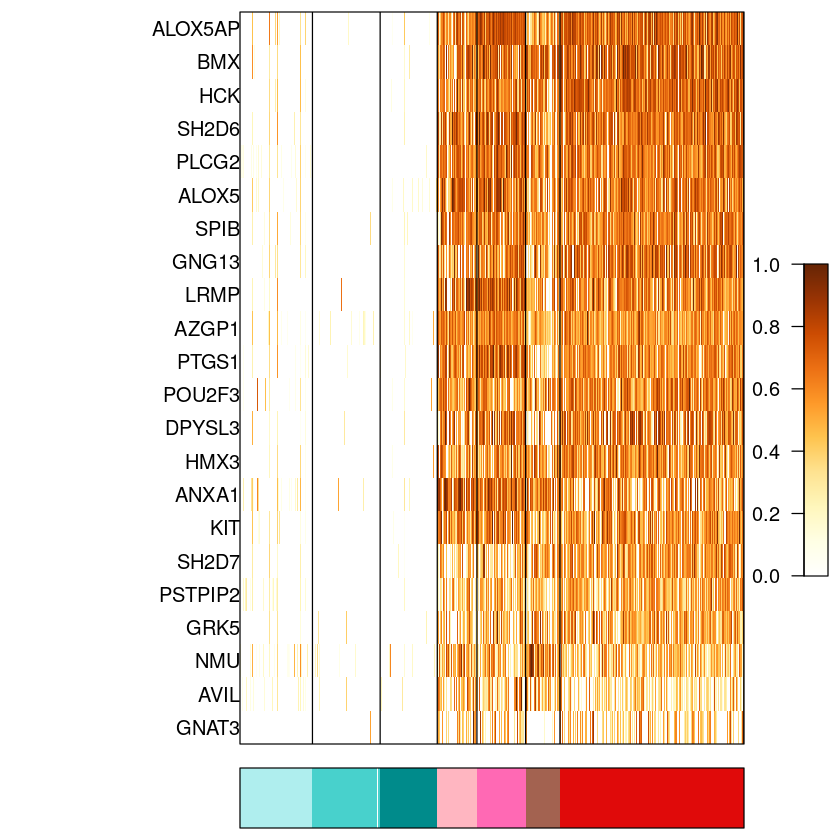

In [28]:
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)
IM = log(1 + 7 * umis_n[ disp_genes,])
IM = IM / apply(IM, 1, quantile, 0.999)
IM = pmin(IM, 1)


vct = factor(sc_names[colnames(IM)], levels = lin_ord); names(vct) = colnames(IM)
good_pops = names(which(table(vct) > 20))
IM = IM[, vct[colnames(IM)] %in% good_pops]
vct = factor(vct[ colnames(IM)], levels = good_pops); names(vct) = colnames(IM)
IM = IM[,names(sort(vct[ colnames(IM)]))]; IM = IM[ order(rowSums(IM)),]
p = function() {
    par(mar = c(0.5, 10, 0.5, 0.5), fig = c(0,0.9,0.1,1))
    image.2(IM, b=F, vct=vct[ colnames(IM)], col=grad, annotate="rows"); box()
    par(fig = c(0,0.9,0,0.1), new=T)
    image(matrix(seq_along(colnames(IM))), axes=F, col = sc_cl@colors[ sc_cl@mc[ colnames(IM)]]); box()
    par(fig = c(0.9,1,0.3,0.7), new=T, mar = c(0.5,2,0.5,0.5))
    image(y = seq(min(IM), max(IM), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2)
    box()
}

p()
pdf(paste0(outdir, "/Fig3d.pdf"), height=10, width=10, useDingbats = F)
p()
dev.off()

## Within

In [29]:
within_genes = sapply(tuft_pops, function(x) scr_chi_square_diff_genes(umis, g1 = names(which(comb == x)), g2 = names(comb)[comb %in% setdiff(tuft_pops, x)], 
                                  pval = 0.01, fdr = T))
names(within_genes) = paste0(names(within_genes), "@")
within_genes = unlist(within_genes)
within_genes = table(within_genes, vecsplit(names(within_genes), "@", 1))
head(within_genes)
dim(within_genes)
#head(Z)


            
within_genes Tuft-1 Tuft-2 Tuft-3 Tuft-4
  A2M-AS1         0      1      0      0
  ABCA1           0      0      0      1
  ABCC3           1      1      0      1
  ABHD2           1      1      1      1
  ABLIM2          0      1      0      0
  AC004012.1      0      0      1      0

[1] 2396    4

In [30]:
Z2 = log2((reg + m[,tuft_pops]) / (reg + apply(m[,tuft_pops], 1, median)))
shared = intersect(rownames(within_genes), rownames(Z2))
table(rowSums(within_genes[shared,] == 1 & Z2[ shared, colnames(within_genes)] > 1))


   0    1 
1556  265 

In [31]:
double_within = within_genes[shared,] == 1 & Z2[ shared, colnames(within_genes)] > 1
colSums(double_within)

Tuft-1 Tuft-2 Tuft-3 Tuft-4 
    12     36    176     41

In [32]:
double_within = double_within[ rowSums(double_within) > 0,]
genes = union(rownames(double_within), core_genes)
gene_anno = rep("Core", length(genes)); names(gene_anno) = genes
gene_anno[ rownames(double_within)] = colnames(double_within)[ max.col(double_within)]
table(gene_anno)

gene_anno
  Core Tuft-1 Tuft-2 Tuft-3 Tuft-4 
   233     12     36    176     41 

rel_genes = names(gene_anno)[ gene_anno %in% c("Core", paste0("Tuft-", 1:4))]

df = data.frame(round(Z2[rel_genes,],3), anno = gene_anno[ rel_genes], umicount = rowSums(umis[rel_genes, tuft_cells ]), mean_count = rowMeans(umis_n[rel_genes, tuft_cells ]))
X = df[ order(df$anno, df$umicount),]

dim(X)
write.table(X, sep = "\t", quote=F, col.names=NA, file = paste0(outdir, "/activation_genes_sc_heatmap.txt"))

table(gene_anno)

In [34]:
good_genes = intersect(names(gene_anno), names(which(apply(Z,1,max) > 1)))
gene_score = rowSums(umis[good_genes, tuft_cells]) #apply(Z[good_genes,], 1, function(x) mean(x[ x > 1]))

disp_genes = setdiff(read.table(paste0(outdir, "/heatmap_genes.txt"), stringsAsFactors = F)[[1]], "ALOX5AP")
table(gene_anno[disp_genes])


Tuft-1 Tuft-2 Tuft-3 Tuft-4 
     2      7      6     10 

IM = lfp[ disp_genes,]
vct = factor(color2name[ sc_cl@colors], levels = lin_ord); names(vct) = seq_along(vct)
hct = factor(gene_anno[disp_genes], levels = c("Core", tuft_pops)); 
names(hct) = disp_genes
IM = IM[,names(sort(vct))]; IM = IM[ order(max.col(IM)),]
image.2(IM, b=T, vct=vct[ colnames(IM)]) #, hct = hct[ rownames(IM)])

zlim: 0<>1
zlim: 0<>1


png 
  2

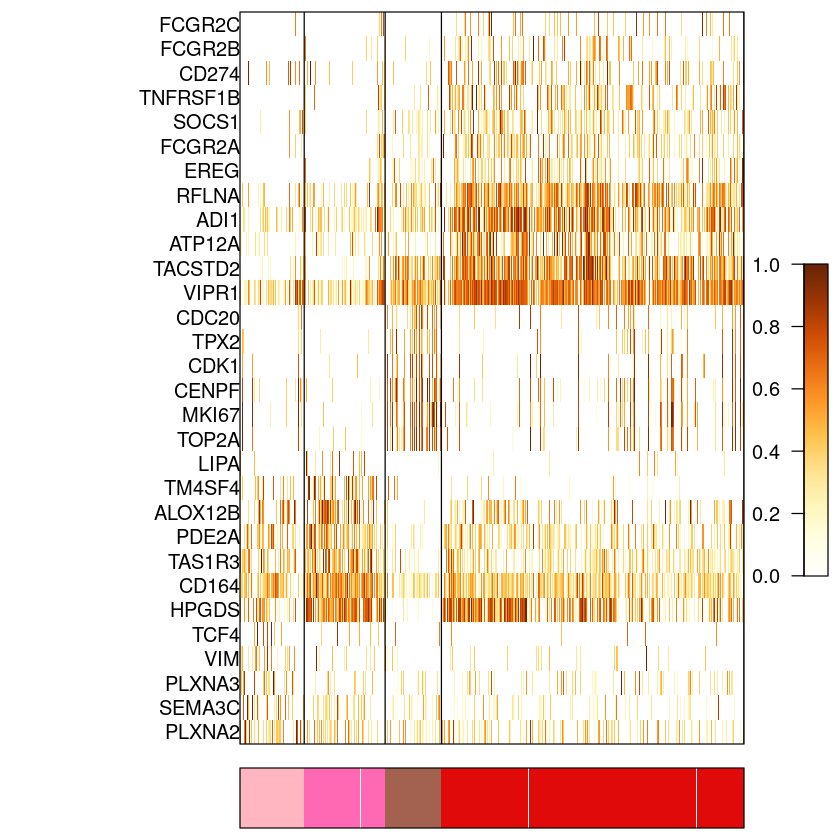

In [35]:
#disp_genes = names(hct)[hct %in% c("tufts_RGS13", "tuft_cc", "tufts_ALOX5AP_activated")]

#disp_genes = names(head(sort(y,T), 40))
grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(1000)
IM = log(1 + 7 * umis_n[ disp_genes, tuft_cells])
IM = IM[, order(factor(sc_cl@mc[ colnames(IM)], levels = clust_ord))]
IM = IM / apply(IM, 1, quantile, 0.999)
IM = pmin(IM, 1)

vct = factor(sc_names[colnames(IM)], levels = lin_ord); names(vct) = colnames(IM)
good_pops = names(which(table(vct) > 20))
IM = IM[, vct[colnames(IM)] %in% good_pops]
vct = factor(vct[ colnames(IM)], levels = good_pops); names(vct) = colnames(IM)
IM = IM[,names(sort(vct[ colnames(IM)]))]; 
IM = IM[ order(max.col(Z[ rownames(IM),]), -rowSums(umis[ rownames(IM), tuft_cells])),]
p = function(IM) {
    par(mar = c(0.5, 10, 0.5, 0.5), fig = c(0,0.9,0.1,1))
    image.2(IM, b=F, vct=vct[ colnames(IM)], col=grad, annotate="rows"); box()
    par(fig = c(0,0.9,0,0.1), new=T)
    image(matrix(seq_along(colnames(IM))), axes=F, col = sc_cl@colors[ sc_cl@mc[ colnames(IM)]]); box()
    par(fig = c(0.9,1,0.3,0.7), new=T, mar = c(0.5,2,0.5,0.5))
    image(y = seq(min(IM), max(IM), length.out = length(grad)), t(seq_along(grad)), col=grad, axes=F)
    axis(2,las=2)
    box()
}

p(IM)
pdf(paste0(outdir, "/Fig3g.pdf"), height=10, width=10, useDingbats = F)
p(IM)
dev.off()


comb2 = interaction(factor(cell_stats$treatment, levels = c("no_cyto", "IL4+IL13")), 
                    cell_stats$amp_batch_id); names(comb2) = rownames(cell_stats)
comb2 = factor(comb2, levels = names(which(table(comb2[ tuft_cells]) > 0)))
names(comb2) = rownames(cell_stats)
table(comb2[ tuft_cells])


pdf(paste0(outdir, "/activation_genes_by_batch.pdf"), height=7, width=21, useDingbats = F)
par(mfrow = c(1,3), mar = c(0.5, 10, 3, 0.5))
for (c in names(table(comb2[ tuft_cells]))) {
    sub_cells = intersect(colnames(IM), names(comb2)[comb2 == c])
    image.2(IM[, sub_cells],
            b=F, vct=vct[ sub_cells], col=grad, annotate="rows"); box()
    title(paste0(c, " (", length(sub_cells), " cells)"))
}
dev.off()


c

x = rowSums(umis[ rownames(Z), tuft_cells]); y = Z2[,"Tuft-4"]

plot(x,y, log="x", pch=20, col = alpha("black", 0.5))
points(x[ disp_genes], y[disp_genes], pch = 20, col = "red", cex = 1.5)

In [36]:
grad = colorRampPalette(c("gray90", "gray90", brewer.pal(3, "Reds")))(101)

plot_feature_maps = function(i, genes, nr = 2, nc = 3, rfac = 5) {
#genes = c("KIT", "POU2F3", "IL4R", "IL27RA", "IL17RB"); i = 1; nr = 1; nc = 1; rfac = 5
    #all_cells = sample(good_cells)
    cb = 1 / nc
    rb = 1 / nr
    locs = cbind(rep(seq_len(nc) - 1, nr), rep(rev(seq_len(nr)) - 1, each = nc))
    gene = genes[i]
    #umis = sc_mat@mat[gene, names(sc_cl@mc)]
    #umis_n = umis / umicount[ names(umis)]
    all_cells = names(sort(umis_n[gene, good_cells]))
    vals = umis_n[gene, good_cells]
    all_cells = names(sort(vals))
    pos_vals = log(1 + 1 * vals[ vals > 0])
    pos_vals = pmin(pos_vals, quantile(pos_vals, 0.99))
    val_n = rep(1, length(all_cells)); names(val_n) = all_cells
    val_n[ names(pos_vals)] = round(100 * pos_vals / max(pos_vals)) + 1
    #grad = colorRampPalette(c("gray80","gray80", "blue3"))(101)
    cell_ord = names(val_n) #sort(val_n))
    r = locs[i,2]; c = locs[i,1]
    par(fig = c(c / nc, c / nc + cb * 0.85, r / nr, r / nr + rb * 0.85), mar = rep(0.5,4), new = (i > 1))
    #plot(df[,"x"], df[,"y"], pch = 20, col = grad[1],
    #    axes = F, xlab = "", ylab = "", cex = 0.7, main = gene)
    df = cbind(x = sc_2d@sc_x[ all_cells], y = sc_2d@sc_y[ all_cells], col = grad[ val_n[ all_cells]], 
               rx = round(sc_2d@sc_x[ all_cells] / rfac), ry = round(sc_2d@sc_y[ all_cells] / rfac))
    df = df[ !duplicated(df[, c("col", "rx", "ry")]),]
    dim(df)
    plot(df[,"x"], df[,"y"], pch = 20, cex = 1, col = df[,"col"], axes = F, xlab = "", ylab = "", main = gene)
    par (fig = c(c / nc + cb * 0.9, c / nc + cb * 1, r / nr + rb * 0.3, r / nr + rb * 0.6), new=T)
    ax = seq(0, max(pos_vals), length.out = length(grad))
    image(y = ax, t(seq_along(grad)), axes = F, col = grad)
    box(); axis(2, at = quantile(ax, c(0,1)), labels = round(quantile(ax, c(0,1)),3), las = 2)
}


png 
  2

png 
  2

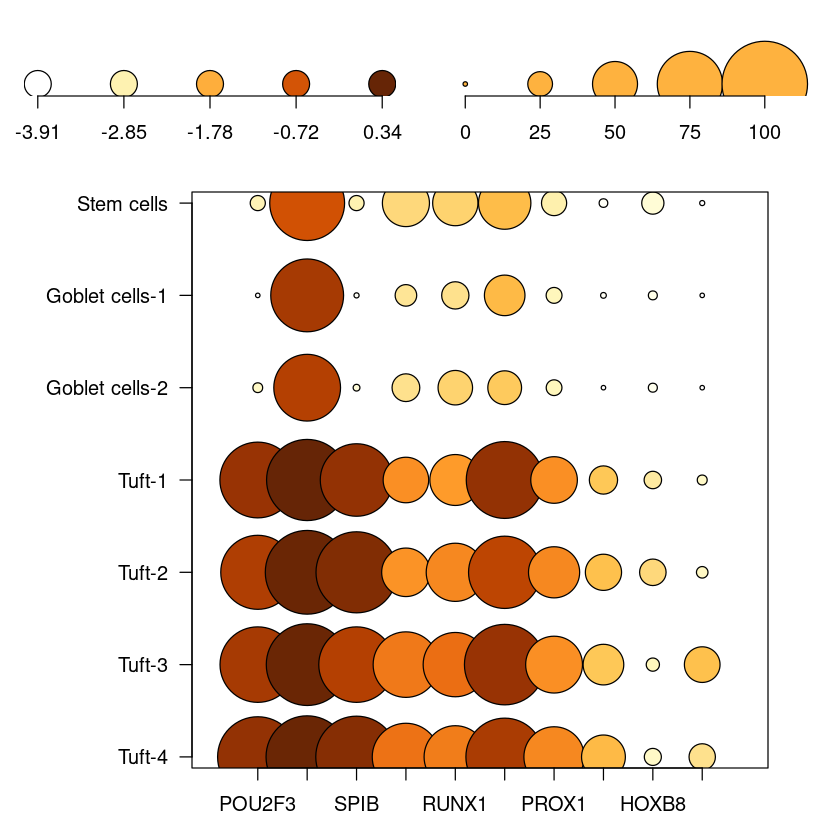

In [39]:

p = function() {
    grad = colorRampPalette(c("white", brewer.pal(9, "YlOrBr")))(101)
    par(mar = c(3,8,1,3))
    matplot.2(t(IM), t(exp_freq), grad=grad, cex_lim = seq(0,100, by = 25))
}


genes = c("POU2F3", "SOX9", "SPIB", "TCF7", "RUNX1", "ZFHX3", "PROX1", "GFI1B", "HOXB8", "HMX2")

m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, rev(intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20))))]
IM = log(m + 0.02)
exp_freq = t(apply(umis[genes, good_cells] > 0, 1, tapply, sc_names[ good_cells], mean))
exp_freq = exp_freq[ ,colnames(m)] * 100

p()
pdf(paste0(outdir, "/Fig3h_left.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

#invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 4))
pdf(paste0(outdir, "/Fig3h_right.pdf"), height=15, width=20, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 4))
dev.off()


png 
  2

png 
  2

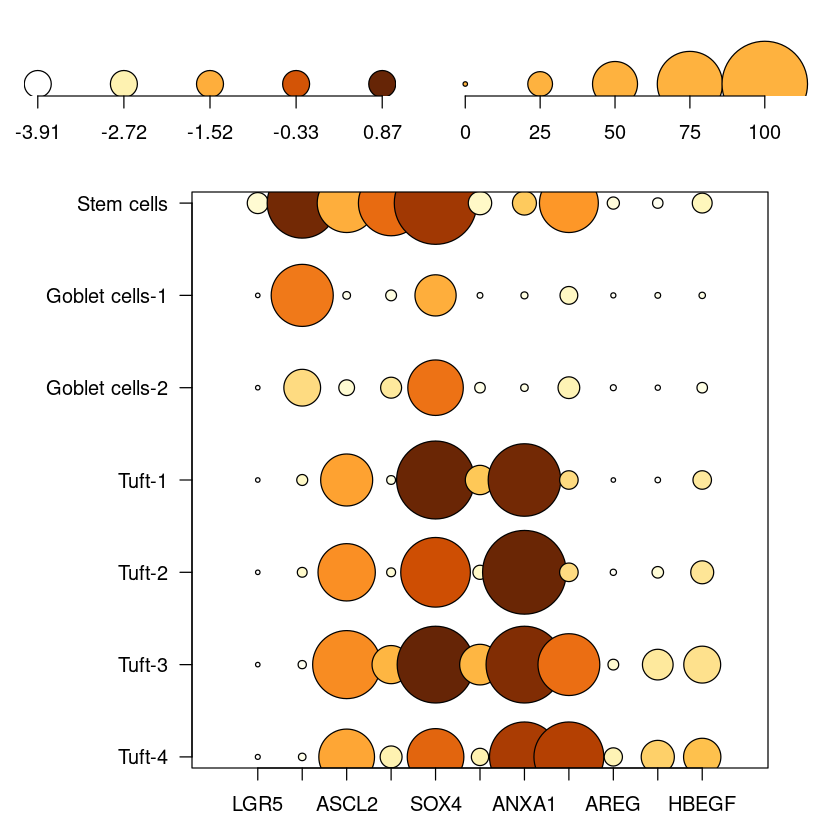

In [41]:
genes = read.table(paste0(outdir, "/stem_genes.txt"), stringsAsFactors = F)[[1]]

m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, rev(intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20))))]
IM = log(m + 0.02)
exp_freq = t(apply(umis[genes, good_cells] > 0, 1, tapply, sc_names[ good_cells], mean))
exp_freq = exp_freq[ ,colnames(m)] * 100

p()
pdf(paste0(outdir, "/Fig5a_left.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

#invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 4))
pdf(paste0(outdir, "/Fig5a_right.pdf"), height=15, width=20, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 3, nc = 4))
dev.off()


In [42]:
genes = c("AVIL", "ALOX5AP", "KIT")
pdf(paste0(outdir, "/FigS4d.pdf"), height=5, width=15, useDingbats=F)
invisible(sapply(seq_along(genes), plot_feature_maps, genes = genes, nr = 1, nc = 3))
dev.off()

png 
  2

png 
  2

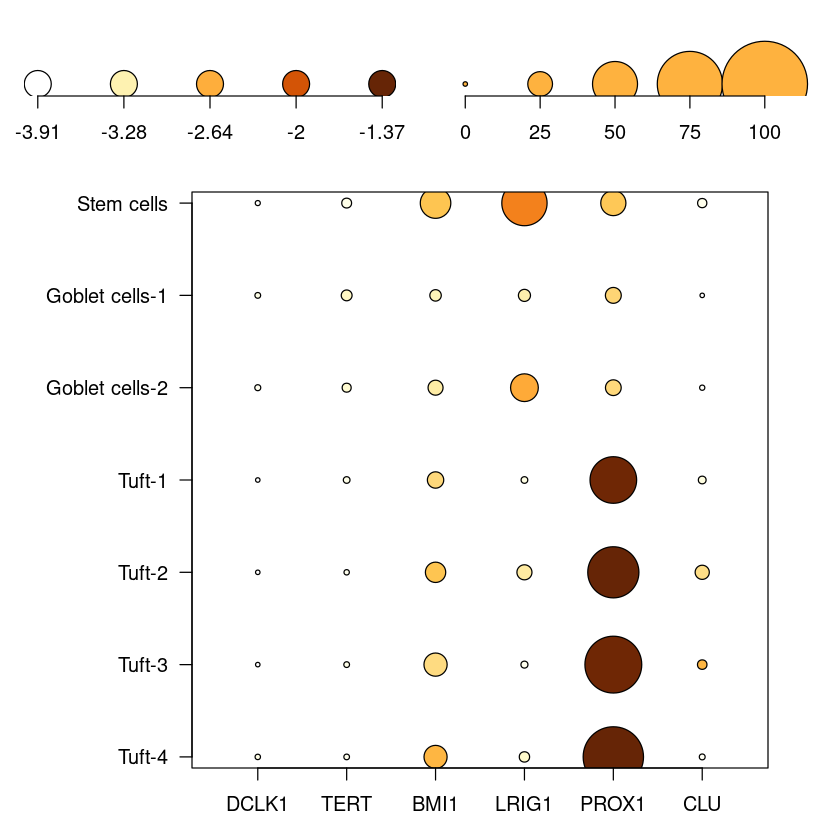

In [43]:
genes = c("DCLK1","TERT", "BMI1", "LRIG1", "PROX1", "CLU")
m = t(apply(umis_n[genes, good_cells], 1, tapply, sc_names[ good_cells], mean))
m = m[, rev(intersect(lin_ord, names(which(table(sc_names[ good_cells]) > 20))))]
IM = log(m + 0.02)
exp_freq = t(apply(umis[genes, good_cells] > 0, 1, tapply, sc_names[ good_cells], mean))
exp_freq = exp_freq[ ,colnames(m)] * 100

p()
pdf(paste0(outdir, "/FigS8a.pdf"), height=10, width=15, useDingbats = F)
p()
dev.off()

Perform GO enrichment analysis on gene_anno

In [44]:
go_df = NULL
for (c in colnames(double_genes)) { #names(table(df$gene_anno))) {
    #genes = rownames(df)[ df$gene_anno == c]
    genes = names(which(double_genes[,c]))
    message("Annotation: ", c, " (", length(genes), " genes)")
    vec = convert2EntrezID(genes, "org.Hs.eg.db", ID_type="gene_symbol")
    gg_bp <- enrichGO(vec, OrgDb = "org.Hs.eg.db", pvalueCutoff=0.05, pAdjustMethod="BH", qvalueCutoff=0.2, readable=TRUE, ont= c("BP"))
    gg_mf <- enrichGO(vec, OrgDb = "org.Hs.eg.db", pvalueCutoff=0.05, pAdjustMethod="BH", qvalueCutoff=0.2, readable=TRUE, ont= c("MF"))
    Y = rbind(cbind(gg_bp@result, ont = "BP"), cbind(gg_mf@result, ont = "MF"))
    Y_genes = sapply(Y[,8], strsplit, "/")
    l = unlist(lapply(Y_genes, length))
    go_df = rbind(go_df, data.frame(gene = unlist(Y_genes), module = rep(Y$Description, l), 
        pval = rep(Y$p.adjust, l), length = rep(l, l), ID = rep(Y$ID, l), ont = rep(Y$ont, l), c=c))
}
head(go_df)


Annotation: Tuft-1 (562 genes)
Annotation: Tuft-2 (692 genes)
Annotation: Tuft-3 (724 genes)
Annotation: Tuft-4 (654 genes)


gene,module,pval,length,ID,ont,c
ACTR2,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
ALKAL1,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
ARHGAP4,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
AVIL,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
COBL,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1
DAB1,regulation of neuron projection development,0.0004119242,35,GO:0010975,BP,Tuft-1


In [45]:
go_df2 = go_df[ go_df$length > 3 & go_df$pval < 0.05,]
go_df3 = unique(go_df2[, c("c", "ID", "module", "pval", "length")])
#nrow(go_df3)

#write.table(go_df3, sep = "\t", quote = F, row.names = F, file = paste0(outdir, "/go_analysis_filtered.txt"))


Revigo = read.delim("figures//figure3_4/Revigo.tsv", row.names=1, stringsAsFactors = F)
head(Revigo)

head(Revigo$Eliminated)
good_go = rownames(Revigo)[ Revigo$Eliminated == "False"]
message(length(good_go), " collpased GO terms")
head(Revigo[good_go,])

In [46]:
head(go_df3)

,c,ID,module,pval,length
1,Tuft-1,GO:0010975,regulation of neuron projection development,0.0004119242,35
36,Tuft-1,GO:0042110,T cell activation,0.0004119242,33
69,Tuft-1,GO:0045785,positive regulation of cell adhesion,0.0011803845,29
98,Tuft-1,GO:0010769,regulation of cell morphogenesis involved in differentiation,0.0011803845,24
122,Tuft-1,GO:0022604,regulation of cell morphogenesis,0.0011803845,32
154,Tuft-1,GO:0045666,positive regulation of neuron differentiation,0.0011803845,27


In [47]:
head(df)

,Epithel,Tuft.1,Tuft.2,Tuft.3,Tuft.4,annotation
ABCB9,0.008008547,0.07082227,0.09807773,0.08728995,0.06843444,Core
ABCC5,0.013309684,0.04658836,0.05979230,0.04270755,0.02920503,Tuft-2
ABCD3,0.086634859,0.18183217,0.23226639,0.19632158,0.20454246,"Tuft-2,Tuft-3,Tuft-4"
ABHD2,0.238401096,0.83755753,1.12846480,0.54320280,0.67184507,Core
AC002044.1,0.003105643,0.01327180,0.02754018,0.03676239,0.02802361,"Tuft-2,Tuft-3,Tuft-4"
AC002044.2,0.012047669,0.08689081,0.03292486,0.07681558,0.08977250,"Tuft-1,Tuft-3,Tuft-4"


In [48]:
#black_list = c()
#good_go = names(table(go_df3$ID))
#go_df2 = go_df[ go_df$ID %in% good_go &(!go_df$module %in% black_list),]
#go_df2 = go_df[ (!go_df$module %in% black_list),]
#go_df3 = unique(go_df2[, c("c", "ID", "module", "pval", "length")])
temp = dcast(go_df3[,c("module", "c", "pval")], module ~ c)
go_pval = as.matrix(temp[,-1]); rownames(go_pval) = temp[,1]

#head(go_length)
#head(go_pval)


Using pval as value column: use value.var to override.


ERROR: Error in head(go_length): object 'go_length' not found


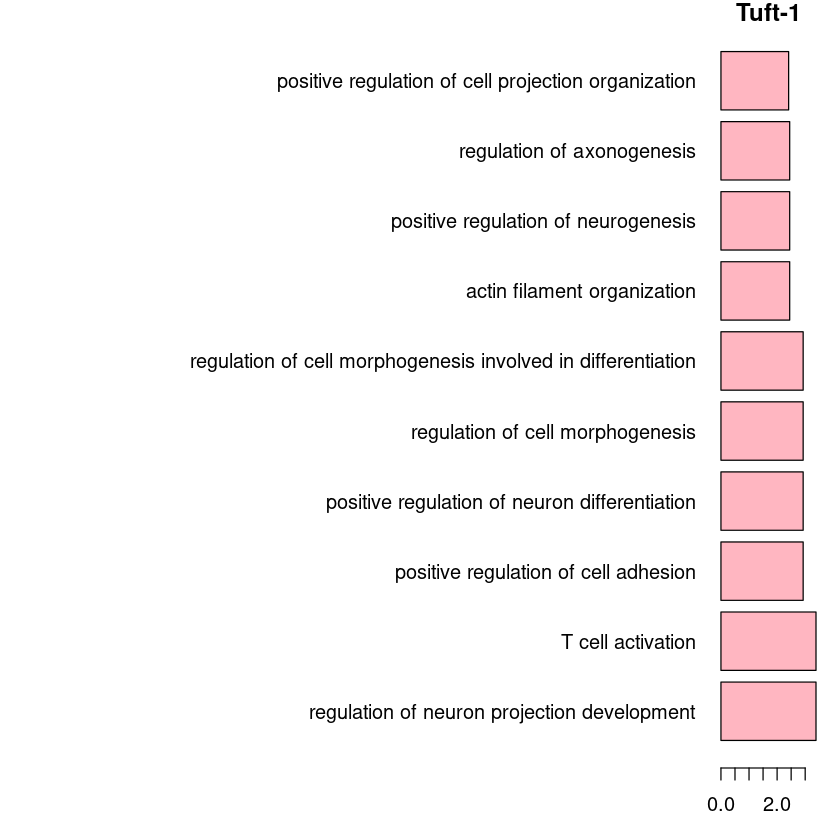

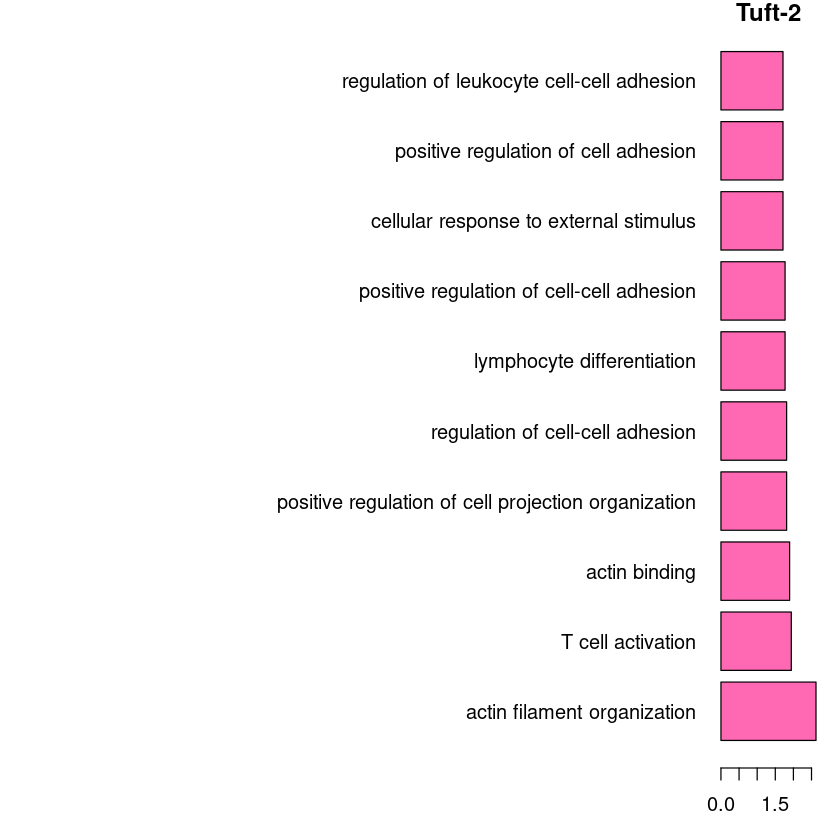

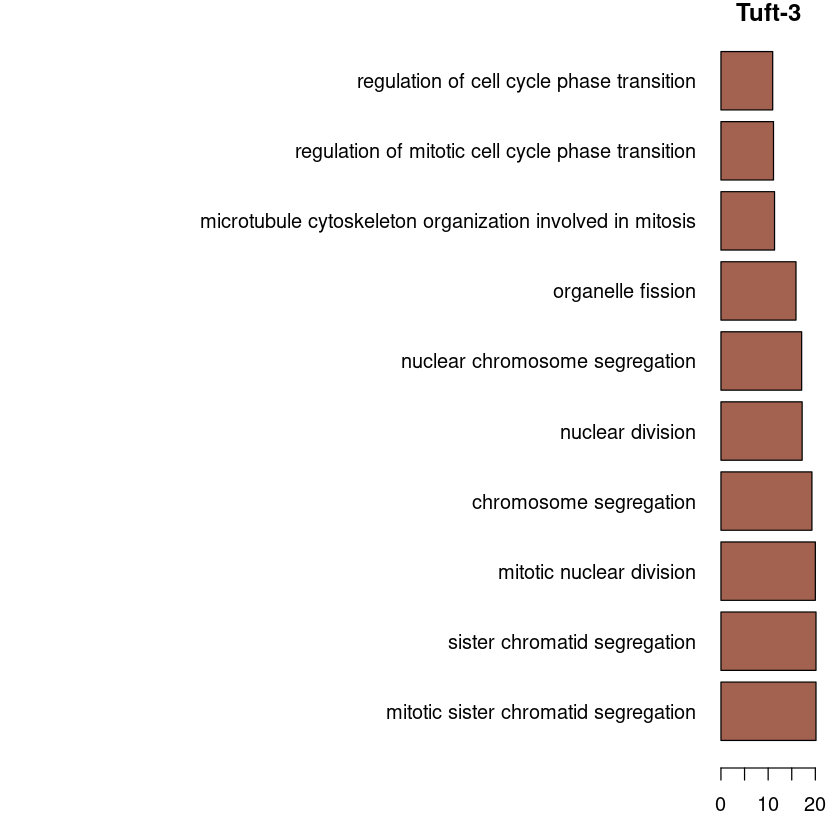

png 
  2

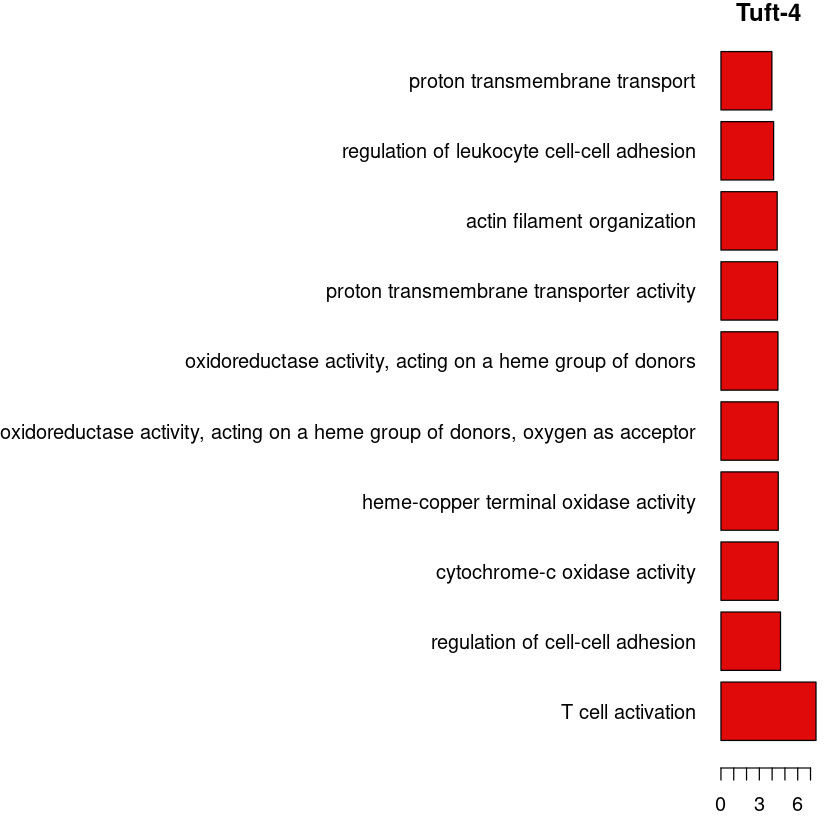

In [49]:
pvals_l = list()

p = function() {
    par(mar = c(3, 30, 1, 1))
    for (c in colnames(go_pval)) {
        pvals = head(sort(go_pval[,c]), 10)
        pvals = pvals[ pvals < 0.05]
        barplot(-log10(pvals), horiz = T, las = 2, axes=F, col = name2color[c])
        title(c); axis(1)
        pvals_l[[c]] = cbind(pvals, module = names(pvals), c)
    }
pvals_l
}

pvals_l = p()
pdf(paste0(outdir, "/FigS4e.pdf"), height=20, width=30)
par(mfrow=c(2,2))
invisible(p())
dev.off()

## tuft-3 vs. tuft-4 signature

In [50]:
table(gene_anno)

gene_anno
  Core Tuft-1 Tuft-2 Tuft-3 Tuft-4 
   233     12     36    176     41 

In [51]:
#tuft_genes = read.delim("figures/figure3_5/activation_genes_sc_heatmap.txt", stringsAsFactors = F, row.names=1)

foc = log(1 + 7 * umis_n)
tuft4_genes = names(which(gene_anno == "Tuft-4"))
score4 = colSums(foc[ tuft4_genes,])

tuft3_genes = names(which(gene_anno == "Tuft-3"))
score3 = colSums(foc[ tuft3_genes,])

#plot(score3, score4, pch = 21, bg = sc_cl@colors[ sc_cl@mc[names(score4)]])

png 
  2


	Wilcoxon rank sum test with continuity correction

data:  score4[names(which(sc_names == "Tuft-3"))] and score4[names(which(sc_names == "Tuft-1"))]
W = 3860, p-value = 2.824e-09
alternative hypothesis: true location shift is not equal to 0



	Wilcoxon rank sum test with continuity correction

data:  score4[names(which(sc_names == "Tuft-3"))] and score4[names(which(sc_names == "Tuft-2"))]
W = 4445, p-value = 2.176e-07
alternative hypothesis: true location shift is not equal to 0


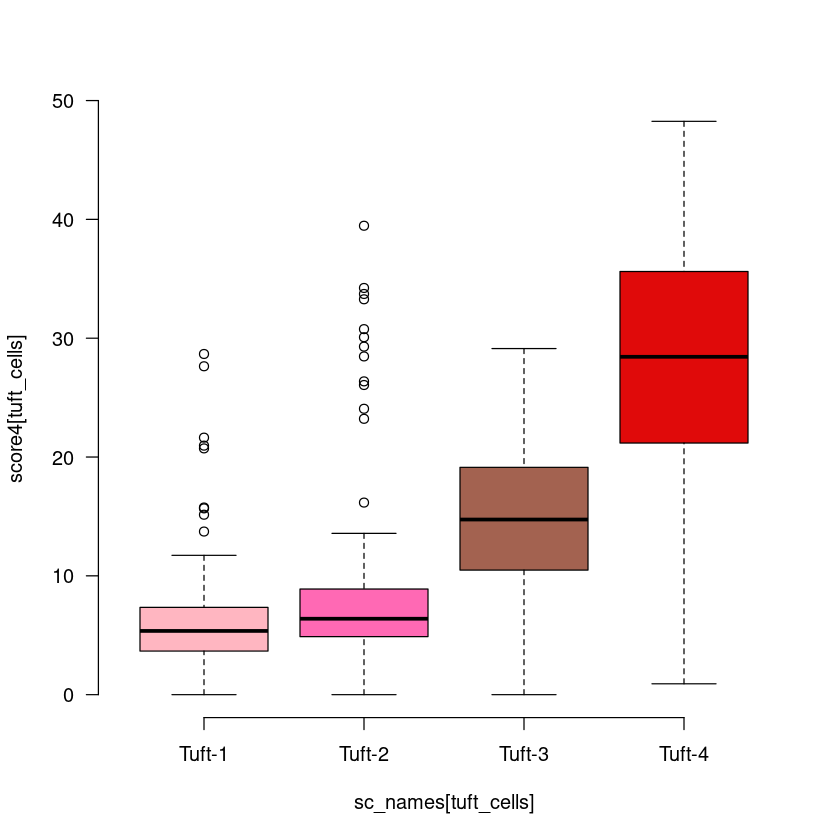

In [53]:
p = function() {
    boxplot(score4[ tuft_cells] ~ sc_names[ tuft_cells], col = name2color[ tuft_pops], axes = F)
    axis(2, las = 2); axis(1, at = seq_along(tuft_pops), labels = tuft_pops)
}

p()
pdf(paste0(outdir, "/FigS4m.pdf"), useDingbats = F)
p()
dev.off()

wilcox.test(score4[ names(which(sc_names == "Tuft-3"))], score4[ names(which(sc_names == "Tuft-1"))])
wilcox.test(score4[ names(which(sc_names == "Tuft-3"))], score4[ names(which(sc_names == "Tuft-2"))])
